<a href="https://colab.research.google.com/github/thanhtai9606/lab-master/blob/main/DeepLearning_for_Timeseries_Forecast_%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from google.colab import drive
drive.mount('/content/drive')
import os
import requests
import io
import pandas as pd

# Define the data directory in Google Drive
data_dir = '/content/drive/MyDrive/data'

# Load the data from CSV into a Pandas dataframe
csv_path = os.path.join(data_dir, 'GEFCom2014-E-1-31 Dec 2014.csv')
energy = pd.read_csv(csv_path)

# Display the first few rows of the dataframe
print(energy.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       Date  Hour     load     T
0  1/1/2012     1 2,698.00 32.00
1  1/1/2012     2 2,558.00 32.67
2  1/1/2012     3 2,444.00 30.00
3  1/1/2012     4 2,402.00 31.00
4  1/1/2012     5 2,403.00 32.00


In [40]:
# If 'timestamp' is not present, identify the correct column name
# and modify the code accordingly. For example, if the date and time
# information is in separate columns 'Date' and 'Hour', you might
# combine them:
if 'timestamp' not in energy.columns:
    if 'Date' in energy.columns and 'Hour' in energy.columns:
        # Replace 24 with 0 to represent midnight
        energy['Hour'] = energy['Hour'].replace(24, 0)
        energy['timestamp'] = pd.to_datetime(energy['Date'] + ' ' + energy['Hour'].astype(str) + ':00:00', format='%m/%d/%Y %H:%M:%S')
    else:
        print("Error: Could not find a suitable timestamp column.")
        # Handle the error appropriately, e.g., exit the script or prompt the user for input

# Set 'timestamp' as the index
energy.set_index('timestamp', inplace=True)



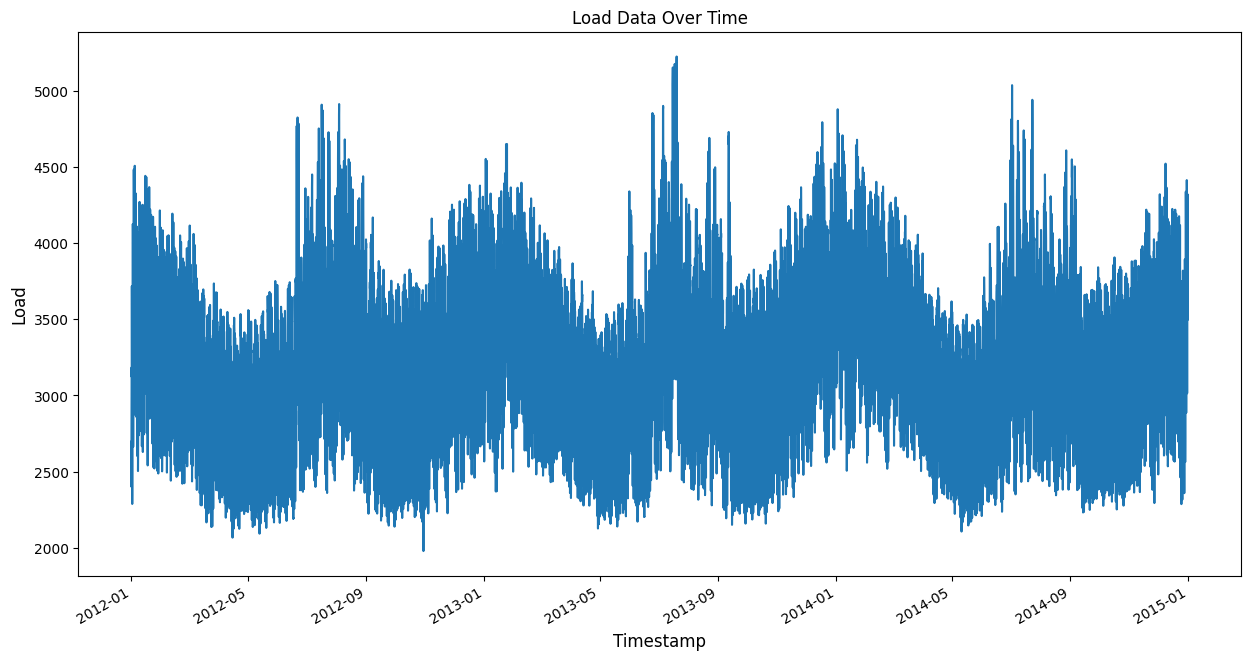

In [41]:
import matplotlib.pyplot as plt

# Plot all available load data
plt.figure(figsize=(15, 8))
energy['load'].plot()
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.title('Load Data Over Time')
plt.show()

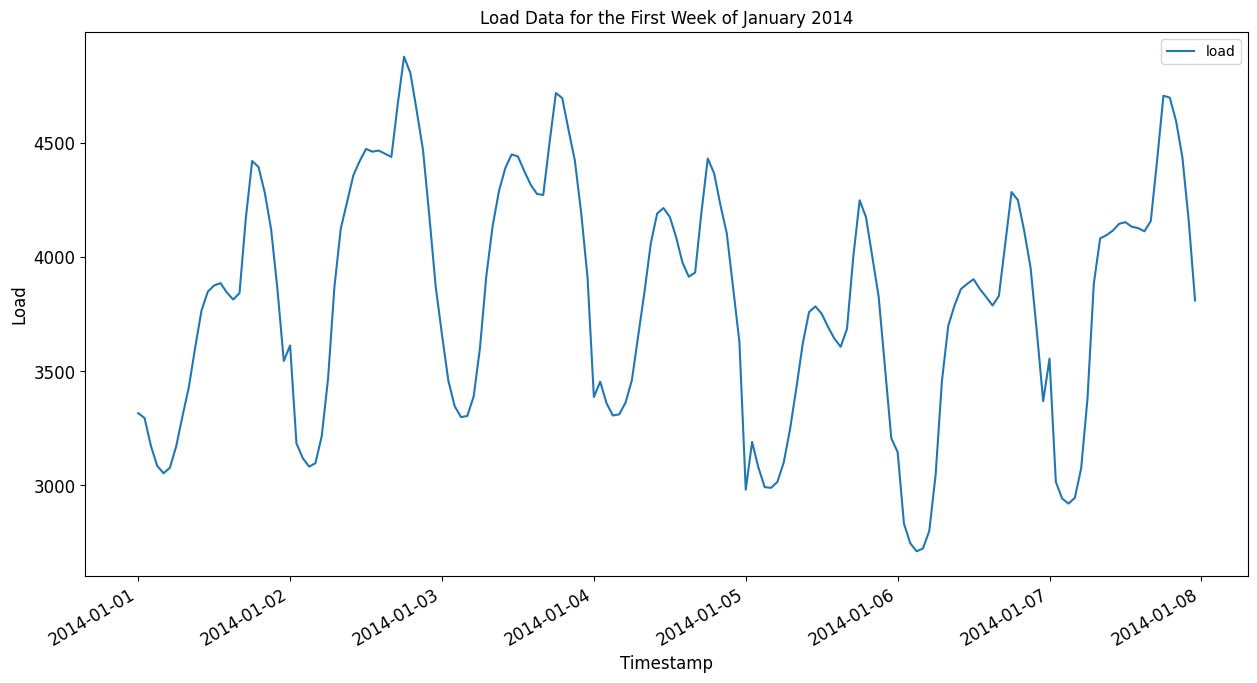

In [42]:
# Plot the first week of Jan 2014
start_date = '2014-01-01'  # Corrected start date to match dataset
end_date = '2014-01-07'    # Corrected end date for the first week
energy[start_date:end_date].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.title('Load Data for the First Week of January 2014')  # Updated title
plt.show()

In [43]:
import os
import pandas as pd
import numpy as np

# Define function to load data
def load_data(data_dir):
    csv_path = os.path.join(data_dir, 'GEFCom2014-E-1-31 Dec 2014.csv')
    df = pd.read_csv(csv_path)
    # Assuming the date and time information is in 'Date' and 'Hour' columns
    if 'Date' in df.columns and 'Hour' in df.columns:
        # Replace 24 with 0 to represent midnight
        df['Hour'] = df['Hour'].replace(24, 0)
        df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00', format='%m/%d/%Y %H:%M:%S')
    else:
        print("Error: Could not find suitable date and time columns.")
        # Handle the error appropriately, e.g., exit or prompt for input
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    return df

# Define function for Mean Absolute Percentage Error (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the data
energy = load_data(data_dir)[['load']]

# Display the first few rows of the dataframe
print(energy.head())

# Convert the data to a more readable format for display
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)


                        load
timestamp                   
2012-01-01 00:00:00 2,639.00
2012-01-01 01:00:00 2,698.00
2012-01-01 02:00:00 2,558.00
2012-01-01 03:00:00 2,444.00
2012-01-01 04:00:00 2,402.00


Create train, validation and test sets
We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [45]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

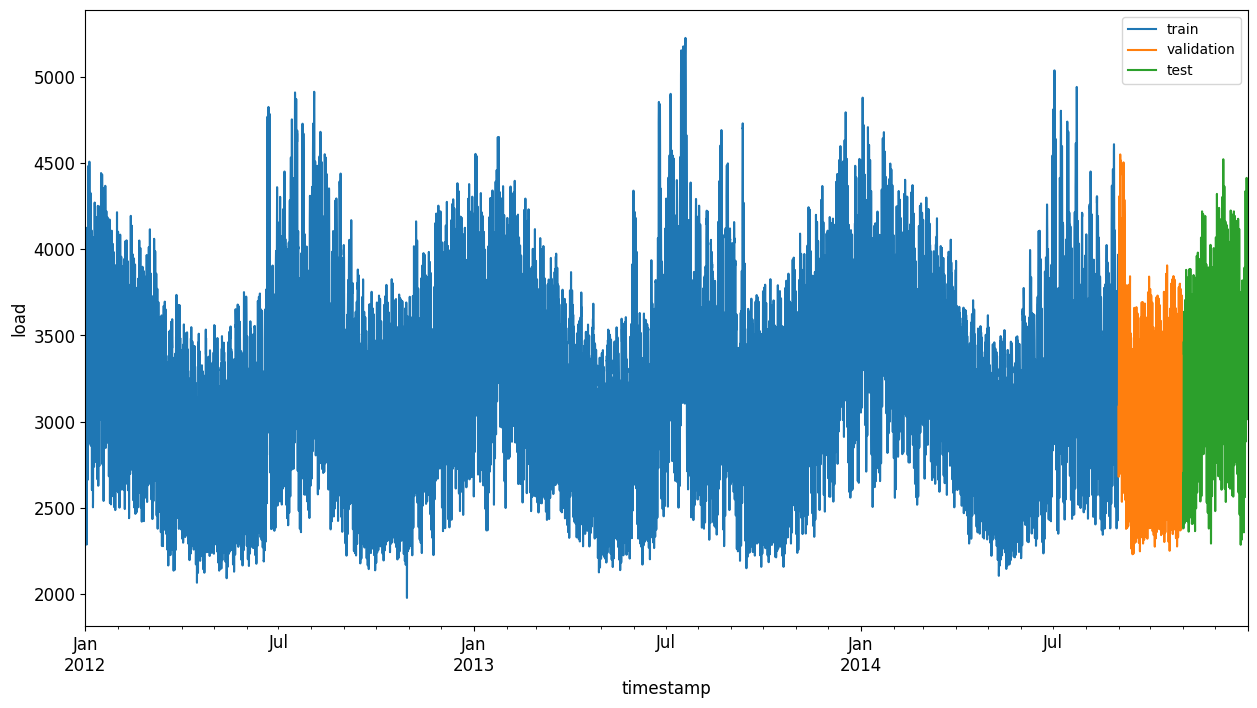

In [46]:
# Plotting
energy[energy.index < valid_start_dt][['load']].rename(columns={'load': 'train'}) \
    .join(energy[(energy.index >= valid_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load': 'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load': 'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Data preparation - training set
For this example, we will set T=10. This means that the input for each sample is a vector of the prevous 10 hours of the energy load. The choice of T=10 was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)
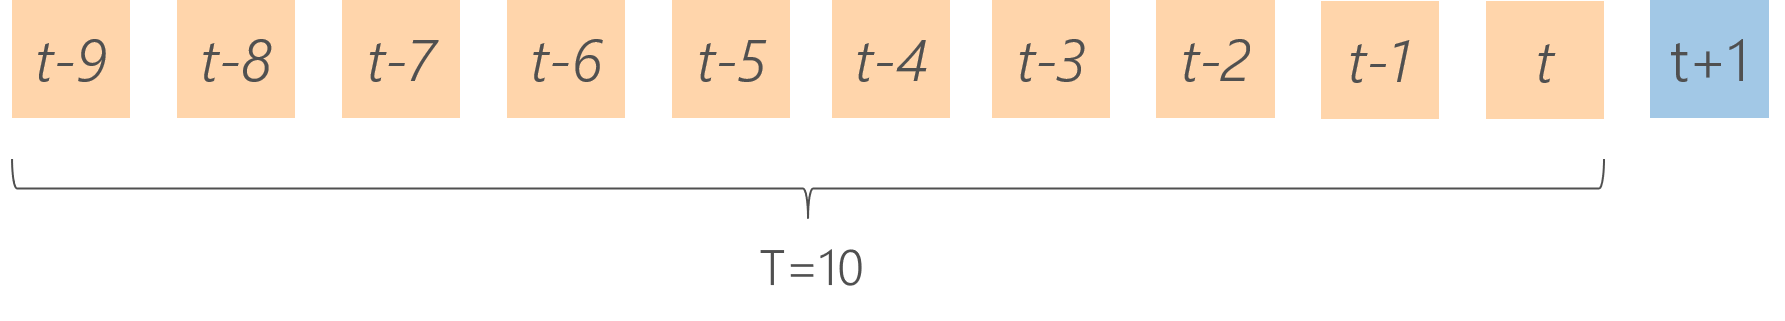

In [47]:
T = 10
HORIZON = 1

Our data preparation for the training set will involve the following steps:

Filter the original dataset to include only that time period reserved for the training set
Scale the time series such that the values fall within the interval (0, 1)
Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
Discard any samples with missing values
Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras
1. Filter the original dataset to include only that time period reserved for the training set
Create training set containing only the model features

In [48]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

2. Scale the time series such that the values fall within the interval (0, 1)
Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2012-01-01 00:00:00,0.20
2012-01-01 01:00:00,0.22
2012-01-01 02:00:00,0.18
2012-01-01 03:00:00,0.14
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.13
2012-01-01 06:00:00,0.15
2012-01-01 07:00:00,0.18
2012-01-01 08:00:00,0.23


Original vs scaled data:

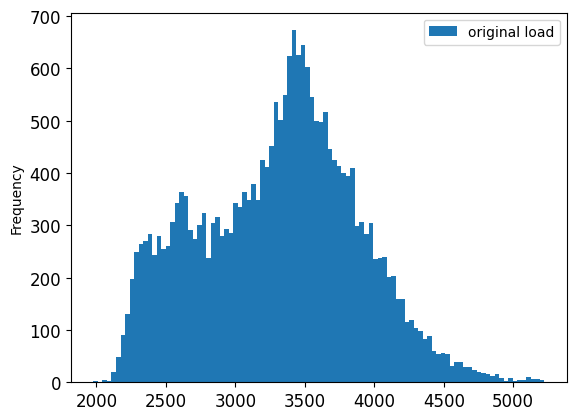

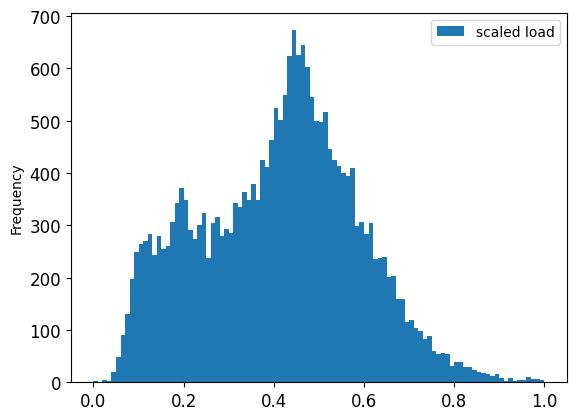

In [50]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
First, we create the target (y_t+1) variable. If we use the convention that the dataframe is indexed on time t, we need to shift the load variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [51]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
timestamp,,
2012-01-01 00:00:00,0.20,0.22
2012-01-01 01:00:00,0.22,0.18
2012-01-01 02:00:00,0.18,0.14
2012-01-01 03:00:00,0.14,0.13
2012-01-01 04:00:00,0.13,0.13
2012-01-01 05:00:00,0.13,0.15
2012-01-01 06:00:00,0.15,0.18
2012-01-01 07:00:00,0.18,0.23
2012-01-01 08:00:00,0.23,0.29


We also need to shift the load variable back 6 times to create the input sequence:

In [52]:
for t in range(1, T+1):
    train_shifted['load_t-'+str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
train_shifted = train_shifted.rename(columns={'load':'load_original'})
train_shifted.head(10)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 00:00:00,0.20,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20
2012-01-01 01:00:00,0.22,0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,0.22
2012-01-01 02:00:00,0.18,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,0.22,0.18
2012-01-01 03:00:00,0.14,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.20,0.22,0.18,0.14
2012-01-01 04:00:00,0.13,0.13,NaN,NaN,NaN,NaN,NaN,0.20,0.22,0.18,0.14,0.13
2012-01-01 05:00:00,0.13,0.15,NaN,NaN,NaN,NaN,0.20,0.22,0.18,0.14,0.13,0.13
2012-01-01 06:00:00,0.15,0.18,NaN,NaN,NaN,0.20,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 07:00:00,0.18,0.23,NaN,NaN,0.20,0.22,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 08:00:00,0.23,0.29,NaN,0.20,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23


4. Discard any samples with missing values
Notice how we have missing values for the input sequences for the first 5 samples. We will discard these:

In [53]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 09:00:00,0.29,0.35,0.20,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 10:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 11:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 12:00:00,0.37,0.37,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 13:00:00,0.37,0.36,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37,0.37,0.37


5. Transform into a numpy arrays of shapes (samples, time steps, features) and (samples,1) for input into Keras
Now convert the target variable into a numpy array.

In [55]:
y_train = train_shifted[['y_t+1']].values

We now have a vector for target variable of shape:

In [56]:
y_train.shape

(23366, 1)

The target variable for the first 3 samples looks like:

In [57]:
y_train[:3]

array([[0.35],
       [0.37],
       [0.37]])

Now convert the inputs into a numpy array with shape (samples, time steps, features)

In [58]:
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_train = X_train[... , np.newaxis]

The tensor for the input features now has the shape:

In [59]:
X_train.shape

(23366, 10, 1)

And the first 3 samples looks like:

In [60]:
X_train[:3]

array([[[0.2 ],
        [0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29]],

       [[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23],
        [0.29],
        [0.35],
        [0.37]]])

In [61]:
train_shifted.head(3)

,load_original,y_t+1,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,,,,,
2012-01-01 09:00:00,0.29,0.35,0.20,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 10:00:00,0.35,0.37,0.22,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 11:00:00,0.37,0.37,0.18,0.14,0.13,0.13,0.15,0.18,0.23,0.29,0.35,0.37


Data preparation - validation set
Now we follow a similar process for the validation set. We keep T hours from the training set in order to construct initial features.



In [62]:
import pandas as pd
import datetime as dt

# Convert valid_start_dt to datetime and calculate look_back_dt
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)

# Filter the DataFrame for the validation period
valid = energy.copy()[(energy.index >= look_back_dt) & (energy.index < test_start_dt)][['load']]

# Display the head of the validation DataFrame
valid.head()

,load
timestamp,
2014-08-31 15:00:00,"3,786.00"
2014-08-31 16:00:00,"3,813.00"
2014-08-31 17:00:00,"3,859.00"
2014-08-31 18:00:00,"3,936.00"
2014-08-31 19:00:00,"3,957.00"


Scale the series using the transformer fitted on the training set:

In [63]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
timestamp,
2014-08-31 15:00:00,0.56
2014-08-31 16:00:00,0.57
2014-08-31 17:00:00,0.58
2014-08-31 18:00:00,0.60
2014-08-31 19:00:00,0.61


Prepare validation inputs in the same way as the training set:

In [66]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid[..., np.newaxis]

In [67]:
y_valid.shape

(1463,)

In [68]:
X_valid.shape

(1463, 10, 1)

Implement the Convolutional Neural Network
We implement the convolutional neural network with 3 layers, 5 neurons in each layer, a kernel size of 3 in each layer, and dilation rates of 1, 2 and 4 for each successive layer.
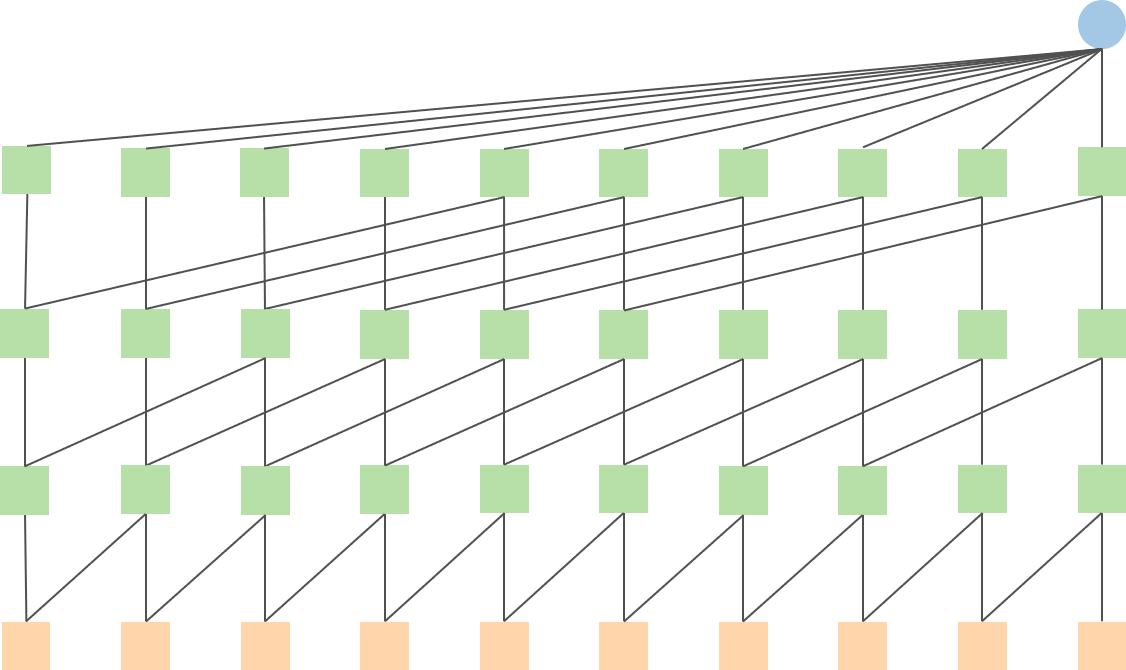

In [69]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [71]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 5)             15        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 5)             55        
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 5)             55        
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 176 (704.00 Byte)
Trainable params: 176 (704.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Use Adam optimizer and mean squared error as the loss function.

In [73]:
model.compile(optimizer='Adam', loss='mse')

Early stopping trick
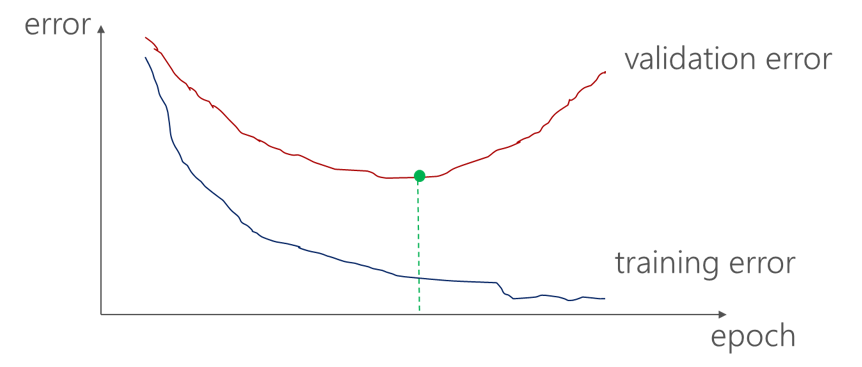

Specify the early stopping criteria. We monitor the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by min_delta after patience epochs, we stop the training.

In [74]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [77]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [78]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
731/731 [==============================] - 6s 3ms/step - loss: 0.0063 - val_loss: 0.0011
Epoch 2/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 7.4595e-04
Epoch 3/10
731/731 [==============================] - 2s 2ms/step - loss: 8.0518e-04 - val_loss: 5.2392e-04
Epoch 4/10
731/731 [==============================] - 2s 2ms/step - loss: 6.8373e-04 - val_loss: 5.1835e-04
Epoch 5/10
731/731 [==============================] - 2s 2ms/step - loss: 6.2750e-04 - val_loss: 3.9960e-04
Epoch 6/10
731/731 [==============================] - 3s 3ms/step - loss: 5.9833e-04 - val_loss: 4.0555e-04
Epoch 7/10
731/731 [==============================] - 3s 4ms/step - loss: 6.0653e-04 - val_loss: 3.7027e-04
Epoch 8/10
731/731 [==============================] - 2s 3ms/step - loss: 5.7522e-04 - val_loss: 3.4644e-04
Epoch 9/10
731/731 [==============================] - 2s 3ms/step - loss: 5.5905e-04 - val_loss: 3.5392e-04
Epoch 10/10
731/731 [===================

oad the model with the smallest mape

In [79]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

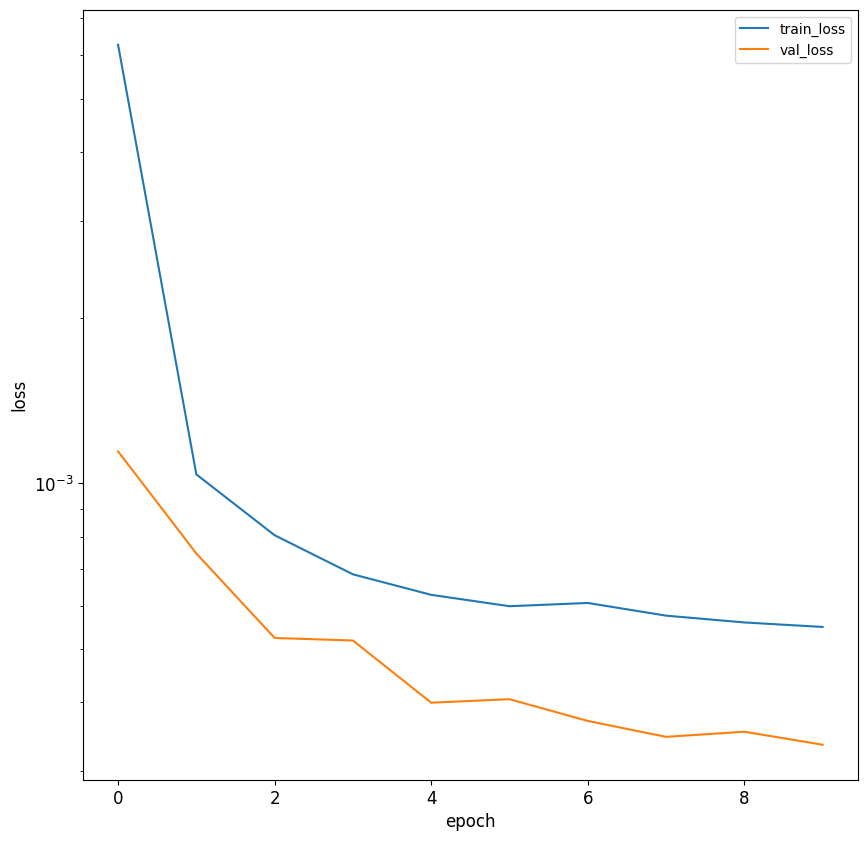

In [80]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

Evaluate the model
Create the test set

In [81]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
timestamp,
2014-11-01 00:00:00,"2,703.00"
2014-11-01 01:00:00,"2,514.00"
2014-11-01 02:00:00,"2,434.00"
2014-11-01 03:00:00,"2,390.00"
2014-11-01 04:00:00,"2,382.00"


Scale the test data

In [82]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-11-01 00:00:00,0.22
2014-11-01 01:00:00,0.16
2014-11-01 02:00:00,0.14
2014-11-01 03:00:00,0.13
2014-11-01 04:00:00,0.12


Create test set features

In [84]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].values
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test[... , np.newaxis]

Make predictions on test set

In [86]:
predictions = model.predict(X_test)
predictions

46/46 [==============================] - 0s 1ms/step


array([[0.4 ],
       [0.46],
       [0.47],
       ...,
       [0.57],
       [0.49],
       [0.44]], dtype=float32)

Compare predictions to actual load

In [87]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 09:00:00,t+1,"3,286.52","3,356.00"
1,2014-11-01 10:00:00,t+1,"3,460.78","3,436.00"
2,2014-11-01 11:00:00,t+1,"3,492.92","3,464.00"
3,2014-11-01 12:00:00,t+1,"3,473.79","3,439.00"
4,2014-11-01 13:00:00,t+1,"3,395.98","3,407.00"


Compute the mean absolute percentage error over all predictions

In [88]:
mape(eval_df['prediction'], eval_df['actual'])

1.4651852374207335

Plot the predictions vs the actuals for the first week of the test set

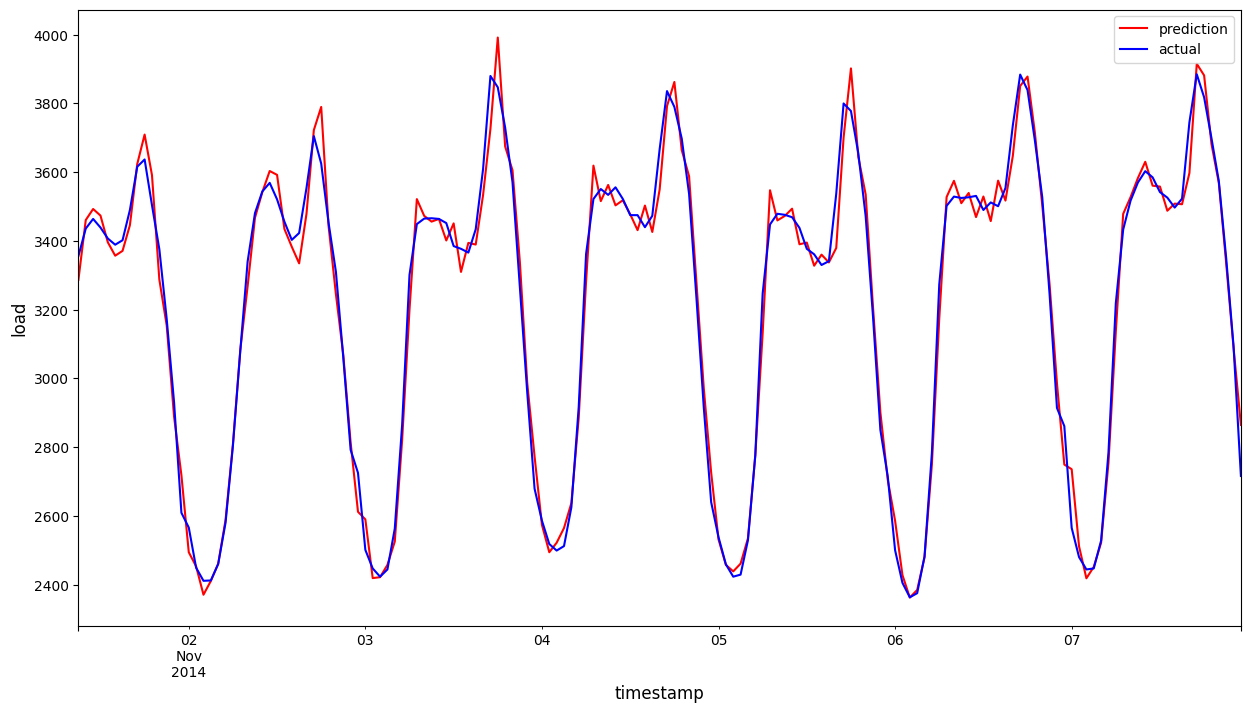

In [89]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

clean up model files

In [91]:
import glob # Import the glob module to use the glob function

for m in glob.glob('model_*.h5'): # Use glob.glob() to find matching files
    os.remove(m)